# 1 Paper Mockup

The paper mock up is identical to the solidworks design seen after. It uses the same measurements as the dynamics II assignments, and is made of cardboard (frame) and cardstock (leg and links). To hold everything together, tape can be used, but the final device would use glue as it would provide a cleaner connection. 

Folded: 
![Alt Text](PaperModelApart.PNG)
![Alt Text](PaperModelAssembled.PNG)

Flattened:
![Alt Text](PaperModelFlat.PNG)

# 2 Solidworks Model

The solidworks model seen here is a 3D version of our design. The folded states depicts both the assembled and exploded view for clarity. The flattened state represents the unfolded assembly in a way that can be used for manufacturing later. The system itself consists of 3 main parts, the sarrus linkages (x2), the frame, and the leg. Holes in the device are for the motor cable to move through, and flaps are used to adhere joints to one another. 

Folded:
![Alt Text](SystemFolded.PNG)
![Alt Text](SystemFoldedEXPL.PNG)

Flattened:
![Alt Text](SystemFlattened.PNG)

# 3 DXF file 

The dxf file directly from solidworks (the method of retrieving the yaml file, then getting the dxf) had issues that left every joint. To troubleshoot, we attempted to add more verticies, and even manually adding them in the program draft sight, both to no avail. Eventually, we found a different program called libreCAD that functions similarly to draft sight. This allowed us to finally obtain the proper dxf file needed, with both body (red) and joint (blue) layers. 

![Alt Text](LibreCADPic.PNG)

# 4 Jupyter Notebook

In [66]:
import foldable_robotics
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import shapely.geometry as sg
foldable_robotics.resolution=4

In [67]:
import foldable_robotics
import foldable_robotics.dxf 
import numpy
import shapely.geometry as sg
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
import idealab_tools.plot_tris
from math import pi, sin,cos,tan
import idealab_tools.text_to_polygons
foldable_robotics.display_height=200
foldable_robotics.line_width=.5

from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics
import foldable_robotics.dxf 
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
foldable_robotics.display_height=200
foldable_robotics.line_width=.5
#import workflow_support as ws

import os
import foldable_robotics.solidworks_support

In [68]:
def get_bodies(filename, layername, num_layers):
    body = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)

    bodies = [Layer(sg.Polygon(item)) for item in body]
    body = bodies.pop(0)
    for item in bodies:
        body ^= item
    body = body.to_laminate(num_layers)
    return body

In [69]:
def get_hinge_lines(filename,layername):
    hinge_lines1 = foldable_robotics.dxf.read_lines(filename,layer=layername)
    hinge_lines2 = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername)
    hinge_lines3 = []
    for points in hinge_lines2:
        hinge_lines3.append(points[:2])
    hinge_lines = hinge_lines1 +hinge_lines3
    return hinge_lines

In [70]:
def hinge_lines_to_hinges(hinge_lines,hinge):
    lam = Layer().to_laminate(len(hinge))
    all_hinges = []    
    for p3,p4 in hinge_lines:
        all_hinges.append(hinge.map_line_stretch((0,0),(1,0),p3,p4))
    all_hinges = lam.unary_union(*all_hinges)
    return all_hinges

In [71]:
def get_cuts(filename,layername,thickness,num_layers):
    cut_lines = foldable_robotics.dxf.read_lines(filename,layer=layername)
    cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)
    
    cuts = []
    for item in cut_lines:
        cuts.append(Layer(sg.LineString(item)))
    cuts = Layer().unary_union(*cuts)
    cuts<<=thickness/2
    cuts = cuts.to_laminate(num_layers)
    return cuts   

In [72]:
def get_holes(filename, layername,num_layers):
    holes = foldable_robotics.dxf.read_circles(filename,layer='holes')
    
    holes2 = []
    for center, radius in holes:
        holes2.append(sg.Point(*center).buffer(radius))
    holes_layer = Layer(*holes2)
    holes_lam = holes_layer.to_laminate(num_layers)  
    return holes_lam

In [73]:
def hinge_width_calculator(desired_degrees,thickness):
    theta = (180-desired_degrees)*pi/180
    w=thickness/tan(theta)
    return w

In [74]:
def polys_to_layer(l1):
    l1 = [sg.Polygon(item) for item in l1]
    l11 = Layer(l1.pop(0))
    for item in l1:
        l11 ^= Layer(item)
    return l11

In [75]:
def output_pdf(filename,design2,x,y,layers_separate = True):
    design2 = design2.translate(x,y)
    design2=design2.scale(1/25.4,1/25.4)
    design2=design2.scale(foldable_robotics.pdf.ppi,foldable_robotics.pdf.ppi)
    if isinstance(design2,Laminate):
        if not layers_separate:
            p=foldable_robotics.pdf.Page(filename+'.pdf')
            for d in design2:
    #        d = design2[0]
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
            p.close()
        else:
            for ii,d in enumerate(design2):
                p=foldable_robotics.pdf.Page(filename+'{0:03f}.pdf'.format(ii))
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
                p.close()

    elif isinstance(design2,Layer):
        p=foldable_robotics.pdf.Page(filename+'.pdf')
        for item in design2.exteriors()+design2.interiors():
            p.draw_poly(item)
        p.close()

In [76]:
def build_layer_numbers(num_layers, text_size = None, prop=None):
    text_size = text_size or 1
    prop = prop or {'family':'Arial','size':text_size}
    layer_ids = []
    for ii in range(num_layers): 
    
        l = idealab_tools.text_to_polygons.text_to_polygons('Layer '+str(ii),prop=prop)
        layer_ids.append(l)
    
    layer_ids = [polys_to_layer(item) for item in layer_ids]
    layer_id = Laminate(*layer_ids)
    return layer_id

In [77]:
def build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive):
    num_layers = len(design2)

    layer_id = build_layer_numbers(num_layers,text_size=jig_diameter)

    design_outer = foldable_robotics.manufacturing.unary_union(design2)
    bb1= (design_outer<<jig_hole_spacing/2).bounding_box()
    (x1,y1),p2 = bb1.bounding_box_coords()
    w,h = bb1.get_dimensions()
    w2 = round(w/jig_hole_spacing)*jig_hole_spacing
    h2 = round(h/jig_hole_spacing)*jig_hole_spacing
    
    points = []
    points.append(sg.Point(x1,y1))
    points.append(sg.Point(x1+w2,y1))
    points.append(sg.Point(x1,y1+h2))
    points.append(sg.Point(x1+w2,y1+h2))
    
    layer_id = layer_id.translate(x1+jig_diameter,y1-jig_diameter/2)
    placement_holes2 = Layer(*points)
    placement_holes2<<=(jig_diameter/2)
    sheet = (placement_holes2<<10).bounding_box()
    placement_holes2=placement_holes2.to_laminate(num_layers)
    sheet=sheet.to_laminate(num_layers)
    
    removable_scrap = calculate_removable_scrap(design2,sheet,support_width,is_adhesive)
    
    web = (removable_scrap-placement_holes2)-layer_id
    return web,sheet

In [78]:
def calculate_removable_scrap(design,sheet,width,is_adhesive):
    '''this computes all removable scrap given a sheet, a design, and a clearance width'''
    all_scrap = sheet-design

    ru = foldable_robotics.manufacturing.not_removable_up(design,is_adhesive)
    rd = foldable_robotics.manufacturing.not_removable_down(design,is_adhesive)
    
    removable_scrap_up = all_scrap-(ru<<width)
    removable_scrap_down = all_scrap-(rd<<width)

    removable_scrap = removable_scrap_up|removable_scrap_down
    return removable_scrap

In [79]:
#user_path = os.path.abspath(os.path.expanduser(‘~’)) user_path

In [80]:
folder = 'C:/Users/Jonathan/Documents/Jupyter/Design and Manufacturing Workflow/'                       #folder with yaml file
input_filename = folder+'TESTFlatSystemPart - Sheet1_Drawing View1.yaml'                      #All flattened assemblies
#input_filename = folder+'SarrusLinkage - Sheet1_Drawing View1.yaml'                        #Only sarrus linkage
output_file_name = 'design.dxf'
New_output_file_name = 'designJoints.dxf'

In [81]:
round_digits = 2
prescale=1000
jig_diameter = 5
support_width = 1
kerf = .05
jig_hole_spacing=20
is_adhesive1 = [False]
is_adhesive = [False,True,False,True,False]
arc_approx = 10

In [82]:
foldable_robotics.solidworks_support.process(input_filename,output_file_name,prescale,round_digits)

(<foldable_robotics.layer.Layer at 0x194a0ac8640>,
 [<foldable_robotics.solidworks_support.Component at 0x194a03aa040>])

# 1 Layer manufacturing design approach

Generating a perforated hinge for the single layer design:

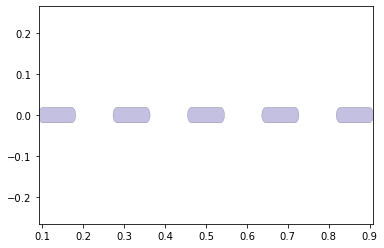

In [83]:
radius = .01
num_perforations = 5
num_segments = num_perforations*2+1
num_points = num_segments+1
a=numpy.r_[0:1:num_points*1j]
lines = []
for ii in range(int(len(a)/2)-1):
    p1 = sg.Point(a[2*ii+1]+radius,0)
    p2 = sg.Point(a[2*ii+2]-radius,0)
    lines.append(sg.LineString((p1,p2)))
hinge = Layer(*lines)
hinge<<=radius
hinge = Laminate(hinge)


w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

In [84]:
NUMLAYERS = len(hinge)
NUMLAYERS

1

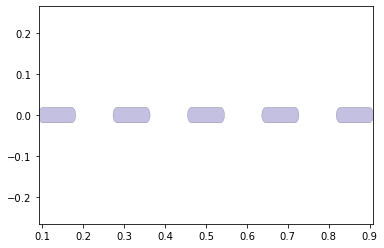

In [85]:
hinge.plot()

Creating the main body of the design from the imported DXF. New_output_file_name is the modified design.dxf file.

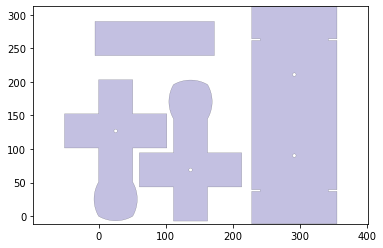

In [86]:
body = get_bodies(New_output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.01)
body.plot()

Plots the perforated hinges at each joint line from the joint layer:

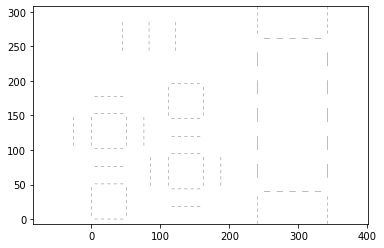

In [87]:
joint_lines= get_hinge_lines(New_output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.001)
joints.plot()

In [88]:
cuts = get_cuts(New_output_file_name,'cuts',.02,NUMLAYERS)
#cuts.plot()

In [89]:
holes = get_holes(output_file_name,'holes',NUMLAYERS)
#holes.plot()

Generate holes at vertices to prevent collision:

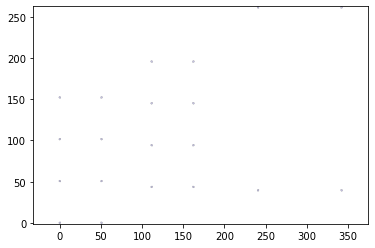

In [90]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

How the end result will look:

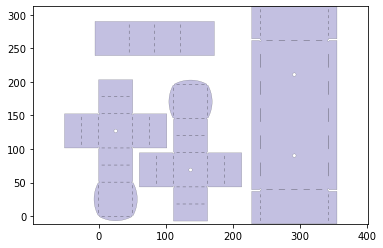

In [91]:
design2 = body- hole - joints - cuts - holes
design2.plot()

Generating the keepout. In the single layer case, it is essentially equivalent to design2.

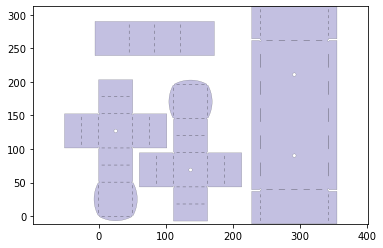

In [92]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
keepout.plot()

Web and sheet generation:

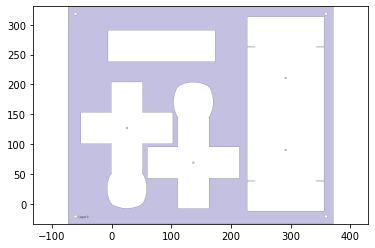

In [93]:
web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive1)
web.plot()

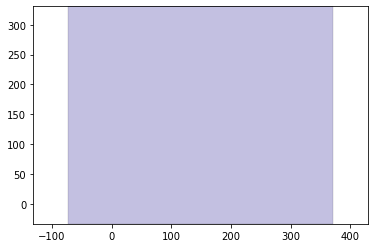

In [94]:
sheet.plot()

Since it is one layer, only a first/single pass in needed.

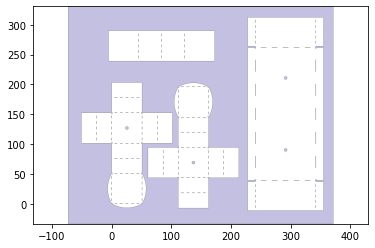

In [95]:
#No cuts at joints, so design2 is the same as the keepout.
first_pass_scrap = sheet - design2
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

Generating support:

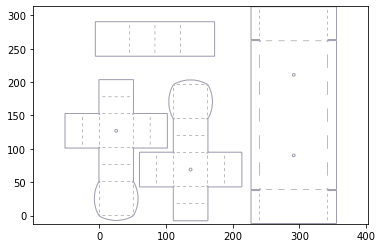

In [96]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

Merging the web, design2 and support into the supported design:

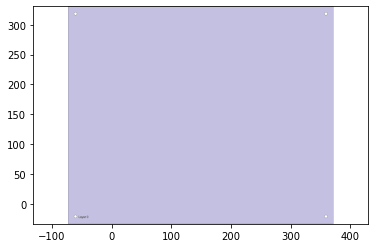

In [97]:
supported_design = web|design2|support
supported_design.plot()

Plotting the material that will be cut and then the final cut itself:

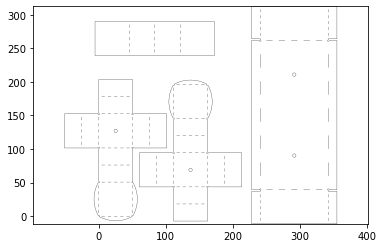

In [98]:
#cut_line = keepout<<kerf
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

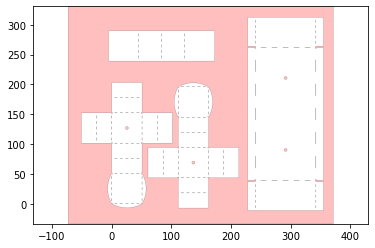

In [99]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

Plotting the material that will remain after the cut:

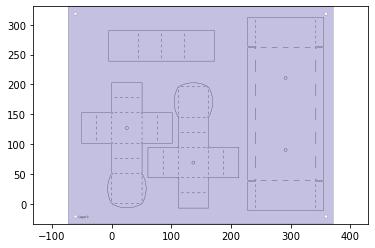

In [100]:
remaining_material = supported_design-cut_material
remaining_material.plot()
#make dxf here

Plots of each separate piece resulting from the cuts:

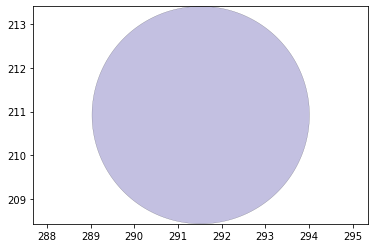

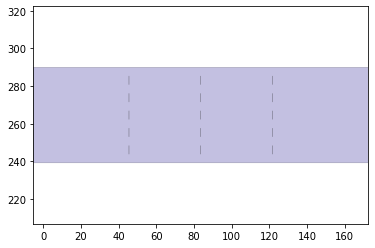

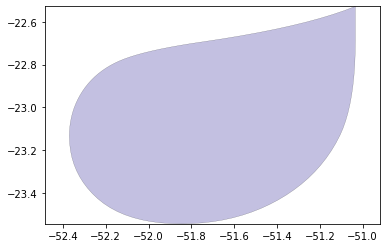

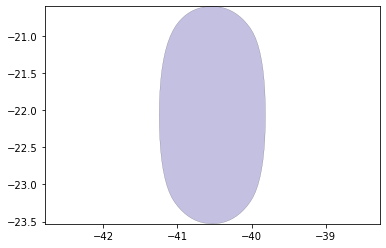

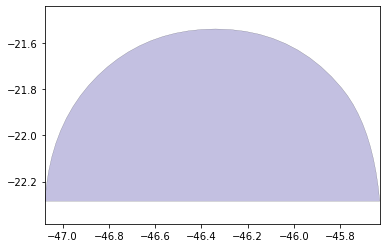

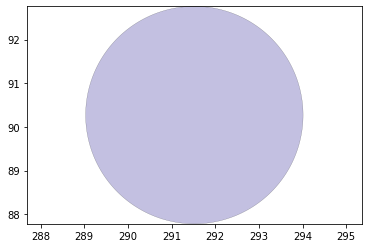

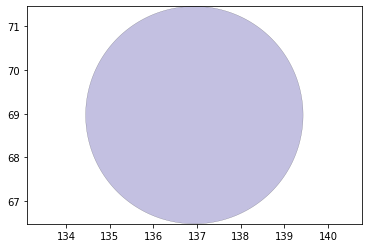

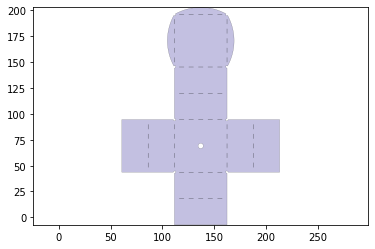

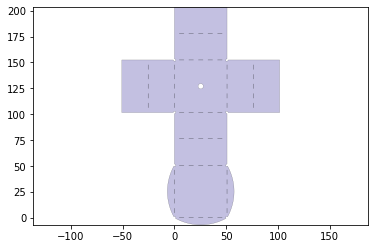

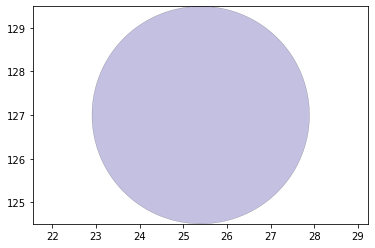

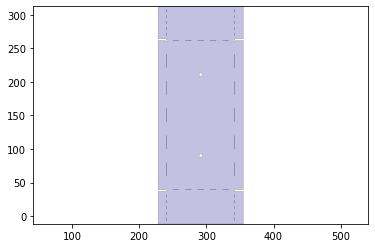

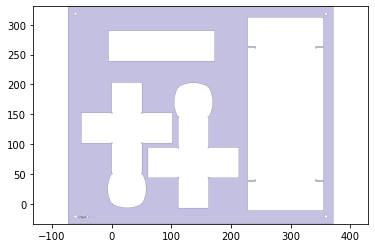

In [101]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive1)
for item in remaining_parts:
    item.plot(new=True)

In [102]:
d3=design2>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
check = (item^design2)
print(check.is_null())

False


Exporting 1-layer DXF:

In [105]:
#if check.is_null():
#    supported_design.export_dxf('first_pass')
#    final_cut.export_dxf('second_pass')

#supported_design.export_dxf('first_pass')
final_cut.export_dxf('Single_Layer_Cut')

# 5 Layer robot design approach

Generate 5 layer castellated hinge:

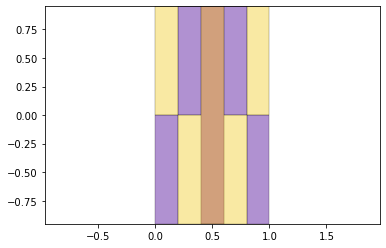

In [106]:
hinge = foldable_robotics.parts.castellated_hinge1.generate()
w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

In [107]:
NUMLAYERS = len(hinge)
NUMLAYERS

5

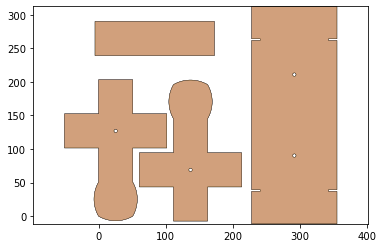

In [108]:
body = get_bodies(New_output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.01)
body.plot()

mapping the hinge design to each joint in your joints layer of the dxf

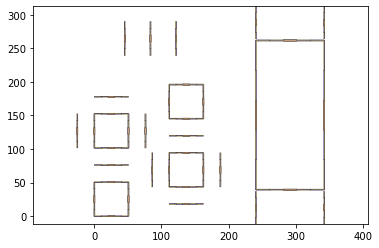

In [109]:
joint_lines= get_hinge_lines(New_output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.02)
joints.plot()

In [110]:
cuts = get_cuts(New_output_file_name,'cuts',.02,NUMLAYERS)
#cuts.plot()

In [111]:
holes = get_holes(output_file_name,'holes',NUMLAYERS)
#holes.plot()

holes computed for any vertices

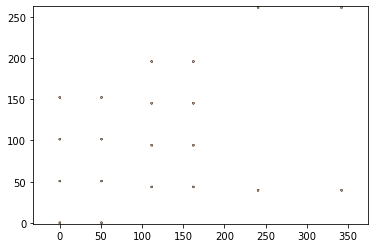

In [112]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

# 5 Layer manufacturing design approach

Subtracting hole, cut, and joint geometries from the body, resulting in the intended design:

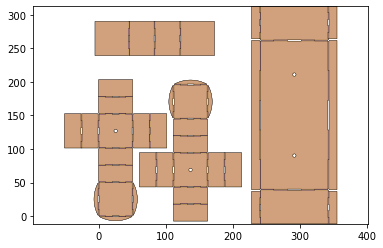

In [113]:
design2 = body- hole - joints - cuts - holes
design2.plot()

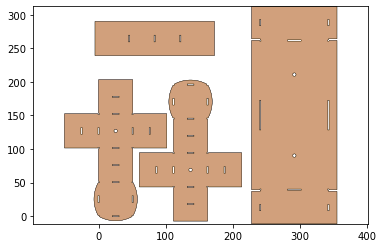

In [114]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
keepout.plot()

Web design

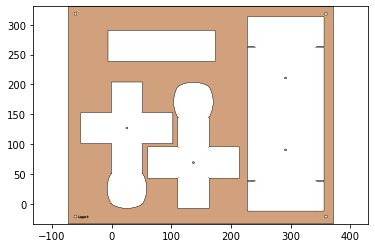

In [115]:
web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()

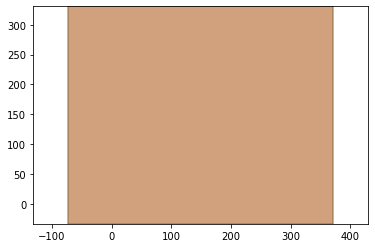

In [116]:
sheet.plot()

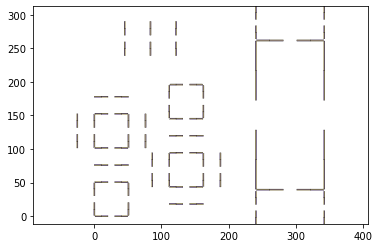

In [117]:
second_pass_scrap = sheet-keepout
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

Support design

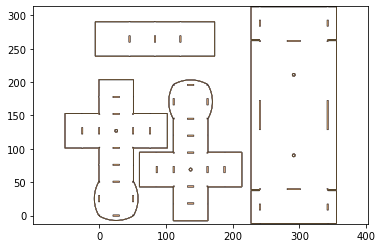

In [118]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

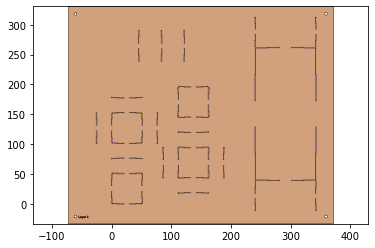

In [119]:
#Calculate the web by using only the material which can be cut, minus a gap determined by the support width.  Is that the only material you can use?
supported_design = web|design2|support
supported_design.plot()

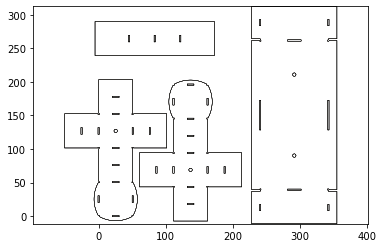

In [120]:
#cut_line = keepout<<kerf
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

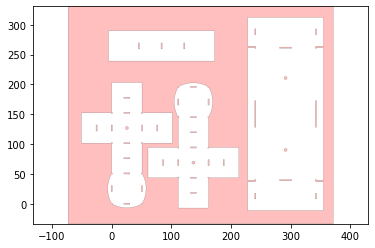

In [121]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

Full cutsheet

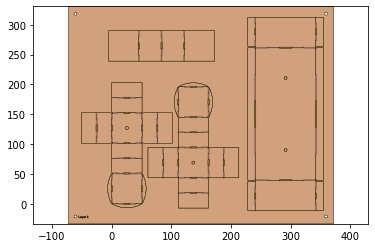

In [122]:
remaining_material = supported_design-cut_material
remaining_material.plot()
#make dxf here

Connection check

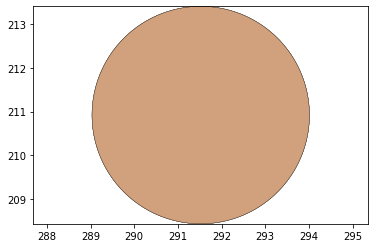

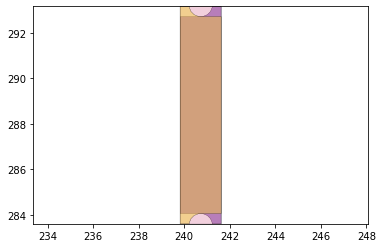

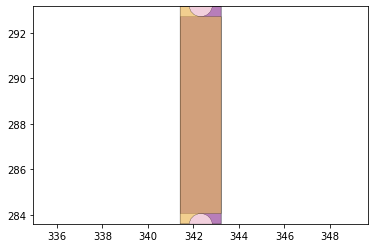

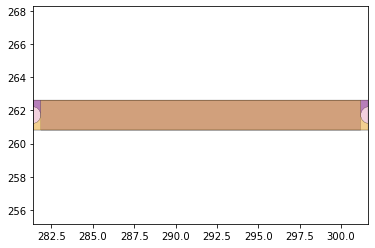

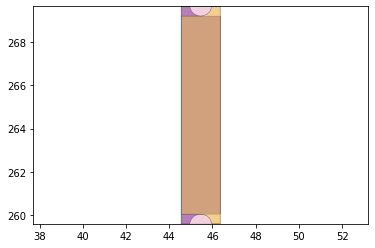

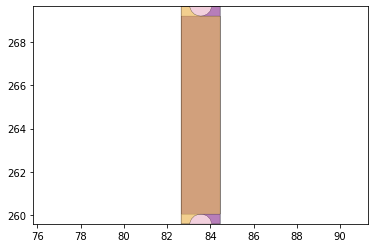

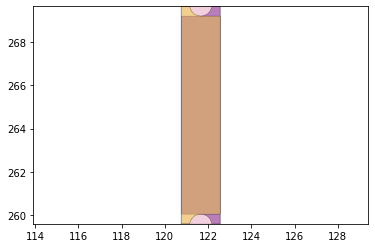

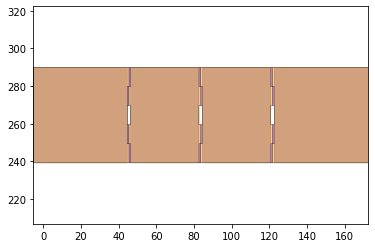

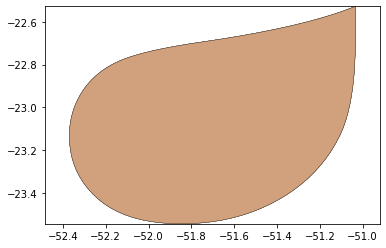

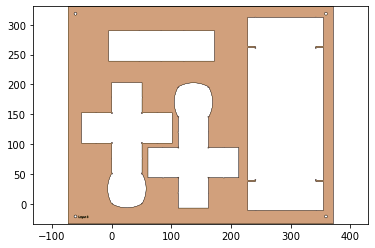

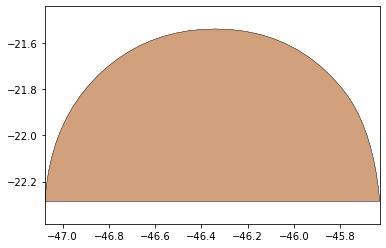

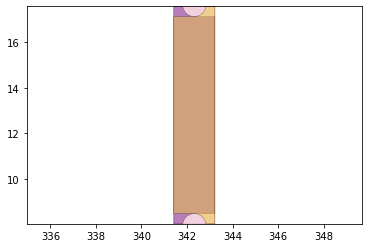

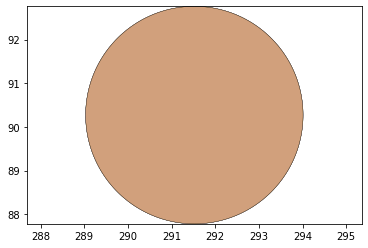

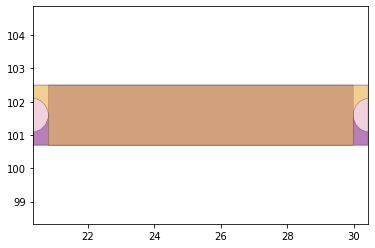

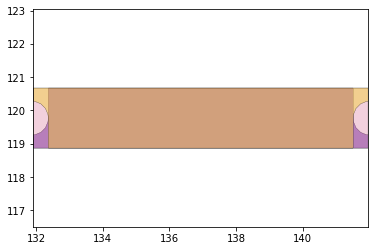

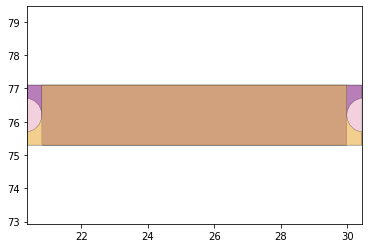

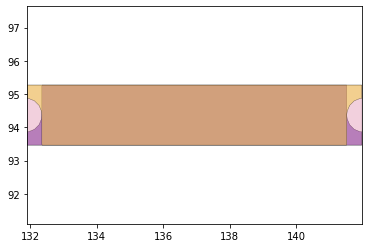

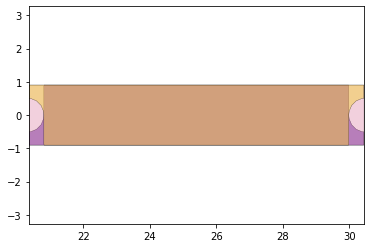

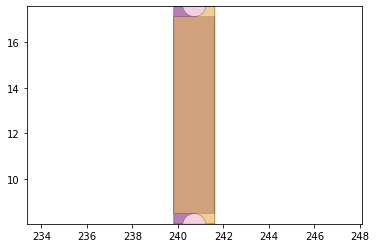

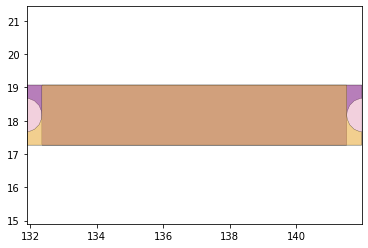

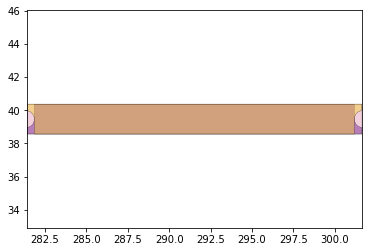

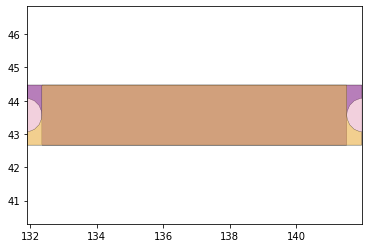

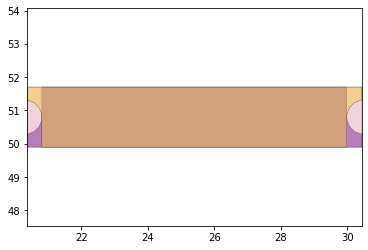

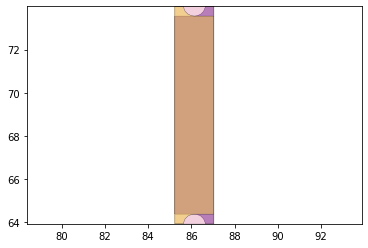

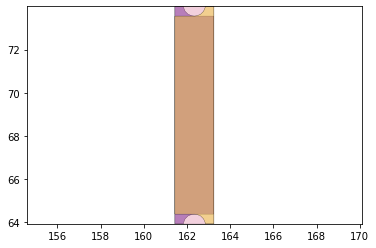

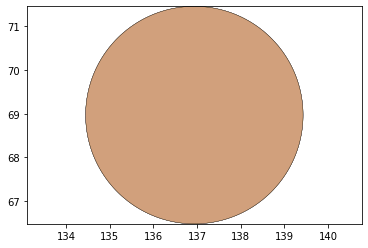

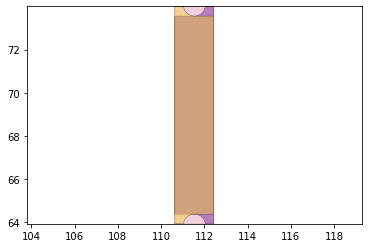

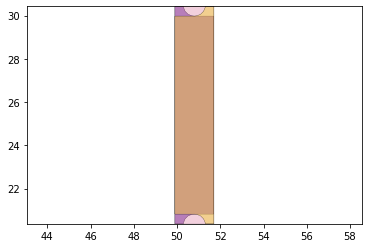

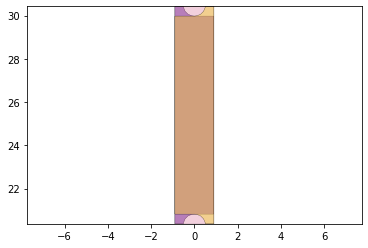

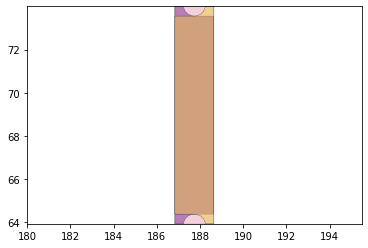

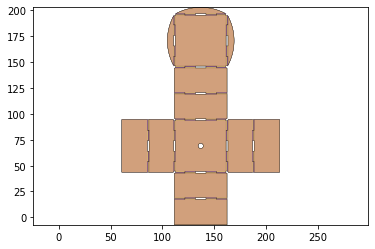

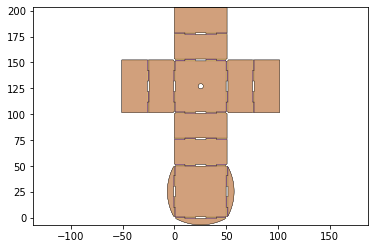

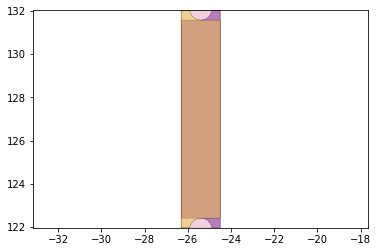

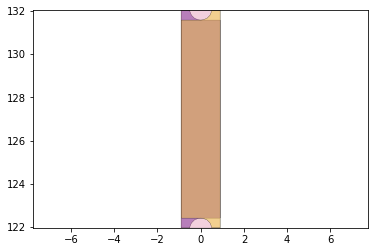

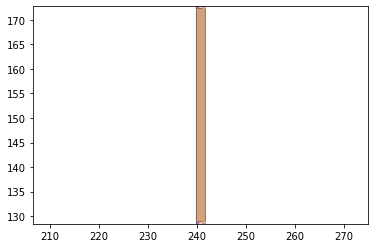

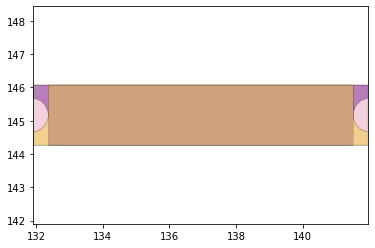

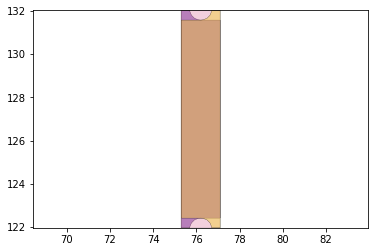

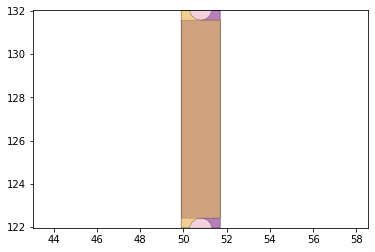

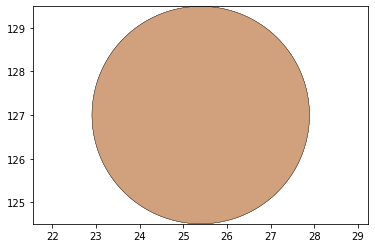

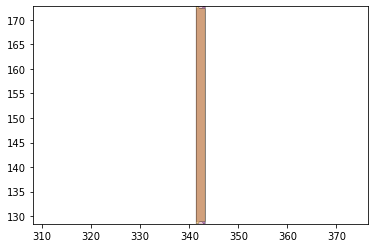

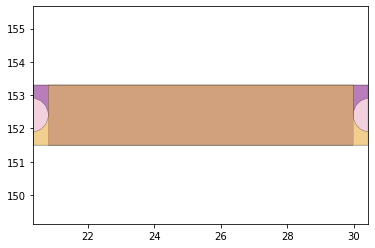

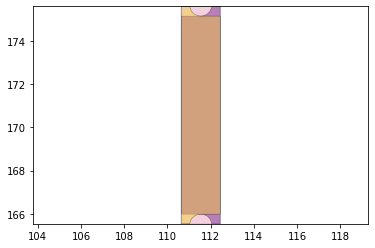

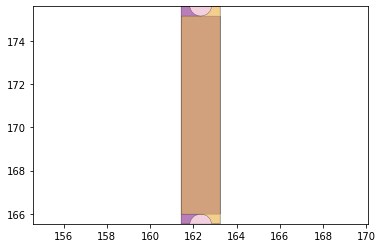

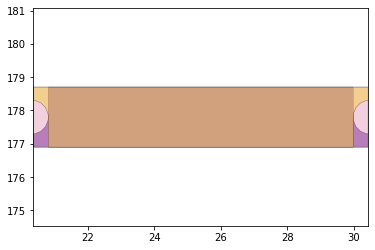

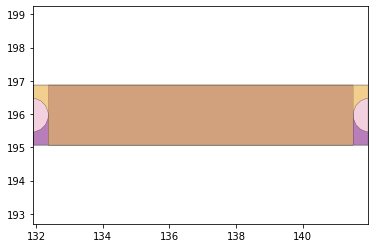

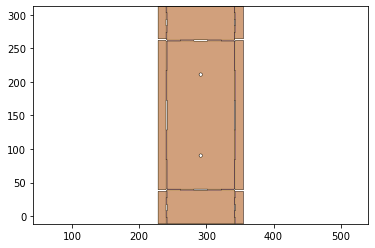

In [123]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

In [124]:
d3=design2>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
check = (item^design2)
print(check.is_null())

False


In [125]:
if check.is_null():
    supported_design.export_dxf('first_pass')
    final_cut.export_dxf('second_pass')
    


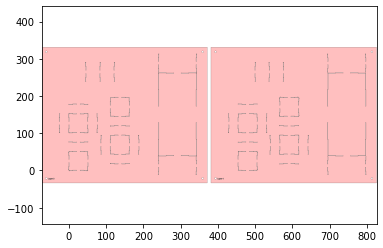

In [59]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()

rigid_layer = supported_design[0] | (supported_design[-1].translate(w+10,0))
rigid_layer.plot()

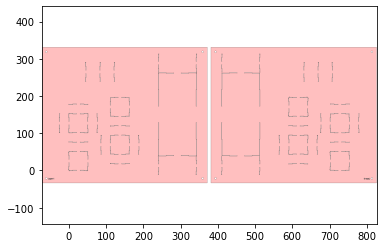

In [60]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+10+w,p0[1]-p2[1])

adhesive_layer = supported_design[1] | l4
adhesive_layer.plot()

In [61]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])
if check.is_null():
    first_pass.export_dxf('first_pass')
    final_cut.export_dxf('final_cut')

In [62]:
check.is_null()

False

Exporting 5-layer DXFs:

In [132]:
rigid_layer.export_dxf('rigid_layer')
adhesive_layer.export_dxf('adhesive_layer')
final_cut.export_dxf('final_cut')

# 5 Final DXF files

Single layer DXF:

![Alt Text](SingleLayer.PNG)

5-layer adhesive DXF:

![Alt Text](AdhesiveLayer.PNG)

5-layer rigid DXF:

![Alt Text](RigidLayer.PNG)

5-layer final cut DXF:

![Alt Text](FinalCut.PNG)